In [1]:
from brainlit.utils.cnn_segmentation import *
from brainlit.utils import make_masks

import warnings

warnings.filterwarnings("ignore")

/Users/shrey2/opt/anaconda3/envs/nd/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


### Downloading Benchmarking Data

In [2]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import os
from pathlib import Path
import numpy as np
from skimage import io
from tqdm import tqdm

In [3]:
cwd = Path(os.path.abspath(""))
data_dir = os.path.join(cwd, "data")
print(f"Downloading segments to {data_dir}")
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

im_dir = Path(os.path.join(data_dir, "sample-tif-location"))
if not os.path.exists(im_dir):
    os.makedirs(im_dir)

swc_dir = Path(os.path.join(data_dir, "sample-swc-location"))
if not os.path.exists(swc_dir):
    os.makedirs(swc_dir)

In [4]:
s3 = boto3.resource("s3", config=Config(signature_version=UNSIGNED))
bucket = s3.Bucket("open-neurodata")
prefix = "brainlit/benchmarking_data/tif-files"  # use this for windows
# prefix = os.path.join("brainlit", "benchmarking_data", "tif-files") #use this for mac/linux
im_count = 0
for _ in bucket.objects.filter(Prefix=prefix):
    im_count += 1
for i, im_obj in enumerate(tqdm(bucket.objects.filter(Prefix=prefix))):
    if im_obj.key[-4:] == ".tif":
        im_name = os.path.basename(im_obj.key)
        im_path = os.path.join(im_dir, im_name)
        bucket.download_file(im_obj.key, im_path)

52it [11:33, 13.34s/it]


In [5]:
s3 = boto3.resource("s3", config=Config(signature_version=UNSIGNED))
bucket = s3.Bucket("open-neurodata")
prefix = "brainlit/benchmarking_data/Manual-GT"  # use this for windows
# prefix = os.path.join("brainlit", "benchmarking_data", "Manual-GT") #use this for mac/linux
swc_count = 0
for _ in bucket.objects.filter(Prefix=prefix):
    swc_count += 1
for i, swc_obj in enumerate(tqdm(bucket.objects.filter(Prefix=prefix))):
    if swc_obj.key[-4:] == ".swc":
        idx = swc_obj.key.find("Manual-GT")
        swc_name = swc_obj.key[idx:]
        swc_path = os.path.join(swc_dir, swc_name)
        dir = os.path.dirname(swc_path)
        if not os.path.exists(dir):
            os.makedirs(dir)
        bucket.download_file(swc_obj.key, swc_path)

601it [00:53, 11.24it/s]


In [6]:
# creating image masks
make_masks(data_dir)

### Preprocessing data (preprocess.py)

In [7]:
# getting images and masks
X_img, y_mask = get_img_and_mask(data_dir)

  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
# train/test split of specified test size
X_train, y_train, X_test, y_test = train_test_split(X_img, y_mask, test_percent=0.25)

In [9]:
# getting training subvolumes <- can skip if you do want to train on whole image
X_train_subvolumes, y_train_subvolumes = get_subvolumes(
    X_train, y_train, x_dim=66, y_dim=66, z_dim=20
)

In [10]:
# getting torch objects
train_dataloader, test_dataloader = getting_torch_objects(
    X_train_subvolumes, y_train_subvolumes, X_test, y_test
)

Training features shape: torch.Size([1, 4250, 66, 66, 20])
Testing features shape: torch.Size([1, 12, 330, 330, 100])
Using cpu device


### Training model (performance.py)

In [11]:
# Define your own neural network architecture here


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv3d(1, 1, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        self.Sigmoid = nn.Sigmoid()
        logits = self.Sigmoid(logits)
        return logits


device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
)


In [12]:
# loss_fn = nn.BCELoss()
loss_fn = DiceLoss()
learning_rate = 0.09
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
epochs = 3

pred_list = []
y_list = []
loss_list = []

for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    x_list, y_pred, y, loss = test_loop(test_dataloader, model, loss_fn)

    pred_list.append(y_pred)
    y_list.append(y)
    loss_list.append(loss)

print("Done!")

  0%|                                                     | 0/3 [00:00<?, ?it/s]

Epoch 1
-------------------------------


 33%|███████████████                              | 1/3 [00:14<00:29, 14.51s/it]

Avg test loss: 0.9932302584250768
Epoch 2
-------------------------------


 67%|██████████████████████████████               | 2/3 [00:28<00:14, 14.47s/it]

Avg test loss: 0.9930826673905054
Epoch 3
-------------------------------


100%|█████████████████████████████████████████████| 3/3 [00:46<00:00, 15.59s/it]

Avg test loss: 0.9929339289665222
Done!


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy at epoch 2 is 69.84087465564738
Precision at epoch 2 is 8.873433632571595
Recall at epoch 2 is 69.81770947917717
Percent nonzero at epoch 2 is 30.34612182430364


  0%|          | 0/12 [00:00<?, ?it/s]

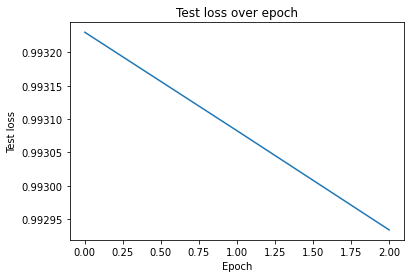

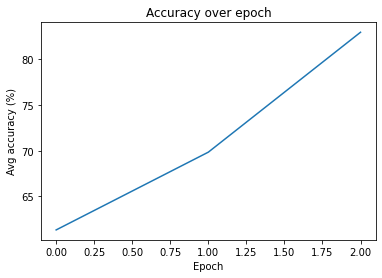

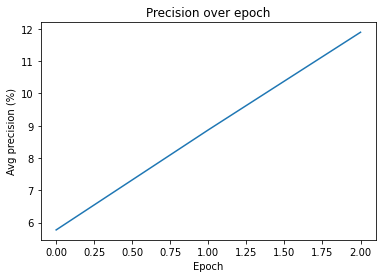

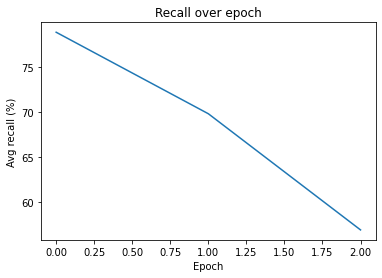

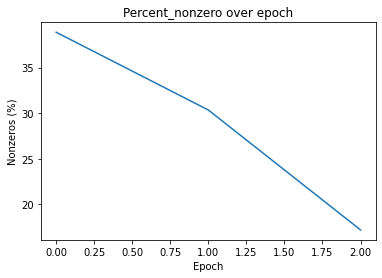

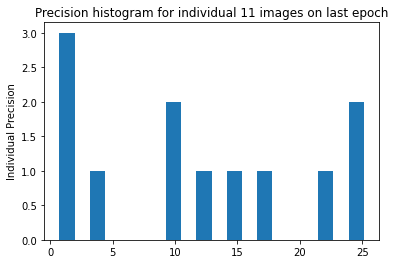

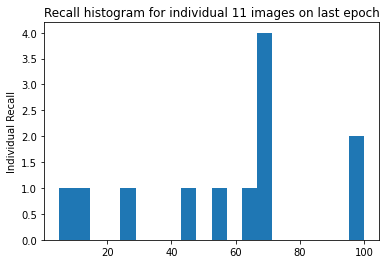

In [13]:
# getting performance metrics over all epochs
acc_list, precision_list, recall_list, percent_nonzero = get_metrics(pred_list, y_list)

# printing performance metrics from specific epoch
quick_stats("all", 2, acc_list, precision_list, recall_list, percent_nonzero)

# plotting metrics
plot_metrics_over_epoch(
    loss_list, acc_list, precision_list, recall_list, percent_nonzero
)

# plotting precision/recall histograms
plot_pr_histograms(pred_list, y_list)

In [14]:
# plotting with napari
plot_with_napari(x_list, pred_list, y_list)